In [1]:
# import warnings
# warnings.filterwarnings("ignore")

import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import scipy
import scipy.signal
import os, os.path

from datetime import date
import datetime
import time

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

import sys

/Users/hn/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [35]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')
import remote_sensing_core as rc
import remote_sensing_plot_core as rcp

start_time = time.time()

In [6]:
data_dir = "/Users/hn/Documents/01_research_data/" + \
           "remote_sensing/01_NDVI_TS/70_Cloud/00_Eastern_WA_withYear/2Years/"

param_dir = "/Users/hn/Documents/00_GitHub/Ag/remote_sensing/parameters/"

In [7]:
####################################################################################
###
###      Parameters                   
###
####################################################################################

SF_year = 2017
indeks = "EVI"

In [8]:
f_name = "Eastern_WA_" + str(SF_year) + "_70cloud_selectors.csv"
a_df = pd.read_csv(data_dir + f_name, low_memory=False)

##################################################################
##################################################################
####
####  plots has to be exact. So, we need 
####  to filter out NASS, and filter by last survey date
####
##################################################################
##################################################################

a_df = a_df[a_df['county']== "Grant"] # Filter Grant
# a_df = rc.filter_out_NASS(a_df) # Toss NASS
# a_df = rc.filter_by_lastSurvey(a_df, year = SF_year) # filter by last survey date
a_df['SF_year'] = SF_year


# Pipeline

   
   1. Read the data
   2. Remove outlliers and jumps
   3. Regularize
   4. Fill Gaps
   5. Smoothen
   6. Find peaks and troughs 
   7. Find SOS and EOS using NDVI ratio of White and TIMESAT.

## 1. Read the data 
(Extract one field)

In [9]:
one_field = a_df[a_df.ID == "101994_WSDA_SF_2017"].copy()

# one_field = one_field[one_field.image_year == 2017].copy()

#
# sort the time series
#
one_field.sort_values(by=['image_year', 'doy'], inplace=True)

#
# reset the damn index to avoid problems if loc and iloc.
#
one_field.reset_index(drop=True, inplace=True)


## add proper date columns to make plotting easier 

In [10]:
one_field['human_system_start_time'] = pd.to_datetime(one_field['image_year'] * 1000 + \
                                                      one_field['doy'], format='%Y%j')

one_field['Date'] = pd.to_datetime(one_field.human_system_start_time.values).values

## 2. Remove outliers and jumps

#### 2a. Remove outliers

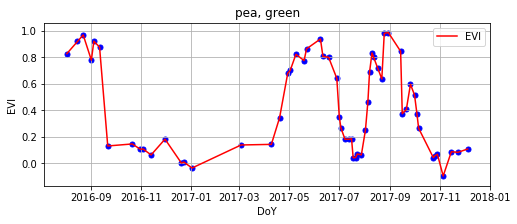

In [11]:
cleaned_field = rc.interpolate_outliers_EVI_NDVI(outlier_input = one_field , given_col = indeks)
fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c='r', label="EVI")

ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='b')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

#### 2b. Remove Jumps

In [12]:
cleaned_field = rc.correct_big_jumps_1DaySeries(dataTMS_jumpie = cleaned_field, 
                                                give_col = indeks, 
                                                maxjump_perDay = 0.015)

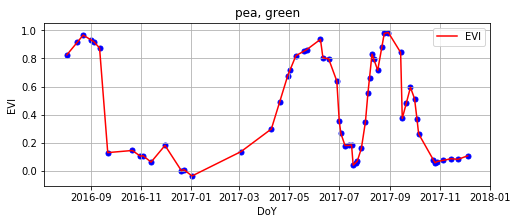

In [13]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c = 'r', label="EVI")

ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='b')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

### 3. Regularize

In [14]:
regular_window_size = 10 
regularized_TS = rc.regularize_movingWindow_windowSteps_2Yrs(one_field_df = cleaned_field, \
                                                             SF_yr = SF_year, \
                                                             veg_idxs = indeks, \
                                                             window_size = regular_window_size)

In [15]:
regularized_TS.head(2)

,ID,Acres,county,CropGrp,CropTyp,DataSrc,ExctAcr,IntlSrD,Irrigtn,LstSrvD,Notes,RtCrpTy,Shap_Ar,Shp_Lng,TRS,image_year,SF_year,doy,EVI
0,101994_WSDA_SF_2017,142.0,Grant,Vegetable,"pea, green",wsda,141.996801,2003/07/01,center pivot,2017/05/20,double cropped peas/wheat/buckwheat,Buckwheat,574640.664088,2828.521582,T14R25E19,2016,2017,213,0.82541
1,101994_WSDA_SF_2017,142.0,Grant,Vegetable,"pea, green",wsda,141.996801,2003/07/01,center pivot,2017/05/20,double cropped peas/wheat/buckwheat,Buckwheat,574640.664088,2828.521582,T14R25E19,2016,2017,223,0.917147


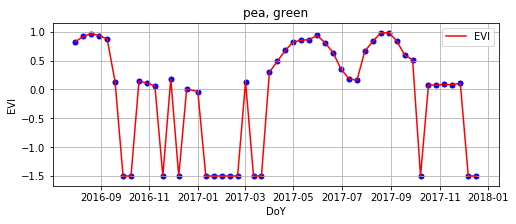

In [16]:
regularized_TS['human_system_start_time'] = pd.to_datetime(regularized_TS['image_year'] * 1000 + \
                                                           regularized_TS['doy'], format='%Y%j')

regularized_TS['Date'] = pd.to_datetime(regularized_TS.human_system_start_time.values).values


fig, ax = plt.subplots(figsize=(8,3));
plot_title = regularized_TS.CropTyp.unique()[0]

ax.plot(regularized_TS['Date'], regularized_TS['EVI'], c = 'r', label="EVI")

ax.scatter(regularized_TS['Date'], regularized_TS['EVI'], marker='o', s=25, c='b')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

### 4. Fill Gaps

In [17]:
regularized_TS = rc.fill_theGap_linearLine(regular_TS = regularized_TS, V_idx = indeks, SF_year = 2017)

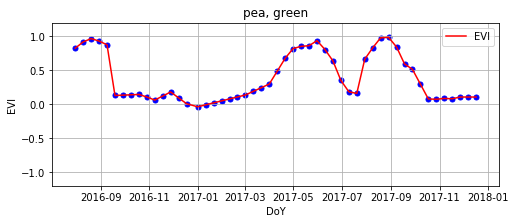

In [18]:
regularized_TS['human_system_start_time'] = pd.to_datetime(regularized_TS['image_year'] * 1000 + \
                                                           regularized_TS['doy'], format='%Y%j')

regularized_TS['Date'] = pd.to_datetime(regularized_TS.human_system_start_time.values).values


fig, ax = plt.subplots(figsize=(8,3));
plot_title = regularized_TS.CropTyp.unique()[0]

ax.plot(regularized_TS['Date'], regularized_TS['EVI'], c = 'r', label="EVI")

ax.scatter(regularized_TS['Date'], regularized_TS['EVI'], marker='o', s=25, c='b')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.set_ylim([-1.2, 1.2])
ax.grid(True)

# We only want to look at one year
We did it here, because our regularization function is written for 1.5 year 

In [19]:
#
# we only want to look at one year
#
clean_regularized_TS = regularized_TS[regularized_TS.image_year == 2017].copy()

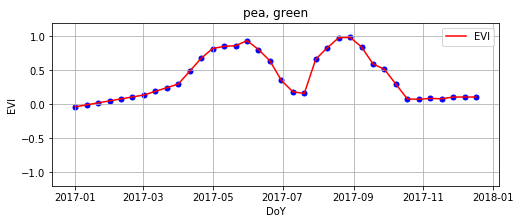

In [20]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = clean_regularized_TS.CropTyp.unique()[0]

ax.plot(clean_regularized_TS['Date'], clean_regularized_TS['EVI'], c = 'r', label="EVI")

ax.scatter(clean_regularized_TS['Date'], clean_regularized_TS['EVI'], marker='o', s=25, c='b')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.set_ylim([-1.2, 1.2])
ax.grid(True)

### 5. Smoothen
This is done inside the plotting function. 
Maybe we can prodduce CSV fine for these and save in on the disk for further use.

## 6. Find peaks and troughs

### (a) MATLAB code converted

In [21]:
# crr_fld = clean_regularized_TS.copy()
# idx = indeks
# SG_params = [5, 1]
# SFYr = 2017
# ax = [0, 0]
# deltA = 0.4

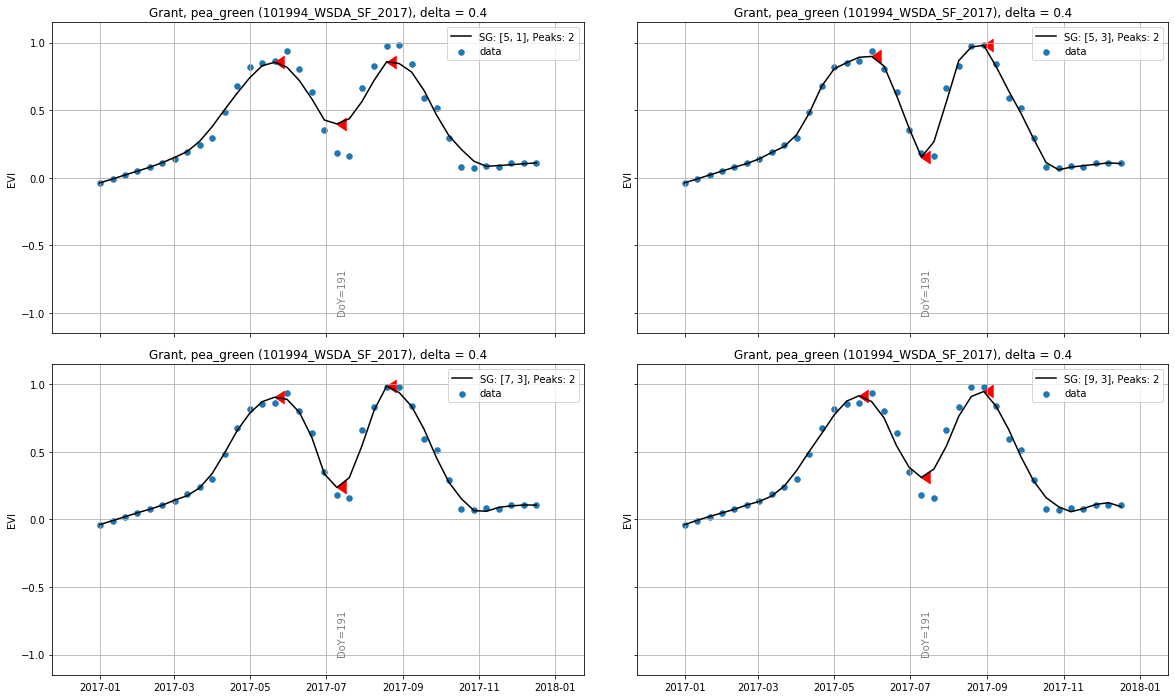

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(20,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2), (ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

rcp.savitzky_1yr_panels_clean_myPeak(crr_fld = clean_regularized_TS, 
                                     idx=indeks, SG_params=[5, 1], 
                                     SFYr=SF_year, ax=ax1, deltA=0.4);

rcp.savitzky_1yr_panels_clean_myPeak(crr_fld = clean_regularized_TS, 
                                     idx=indeks, SG_params=[5, 3], 
                                     SFYr=SF_year, ax=ax2, deltA=0.4); 

rcp.savitzky_1yr_panels_clean_myPeak(crr_fld = clean_regularized_TS, 
                                     idx=indeks, SG_params=[7, 3], 
                                     SFYr=SF_year, ax=ax3, deltA=0.4);

rcp.savitzky_1yr_panels_clean_myPeak(crr_fld = clean_regularized_TS, 
                                     idx=indeks, SG_params=[9, 3],
                                     SFYr=SF_year, ax=ax4, deltA=0.4)


plot_path = "/Users/hn/Desktop/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

fig_name = plot_path + county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'
plt.savefig(fname = fig_name, dpi=250, bbox_inches='tight')

### (b) [Python Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)



In [23]:
# crr_fld = clean_regularized_TS.copy()
# idx = indeks
# SG_params = [5, 1]
# SFYr = 2017
# ax = [0, 0]
# deltA = 0.4

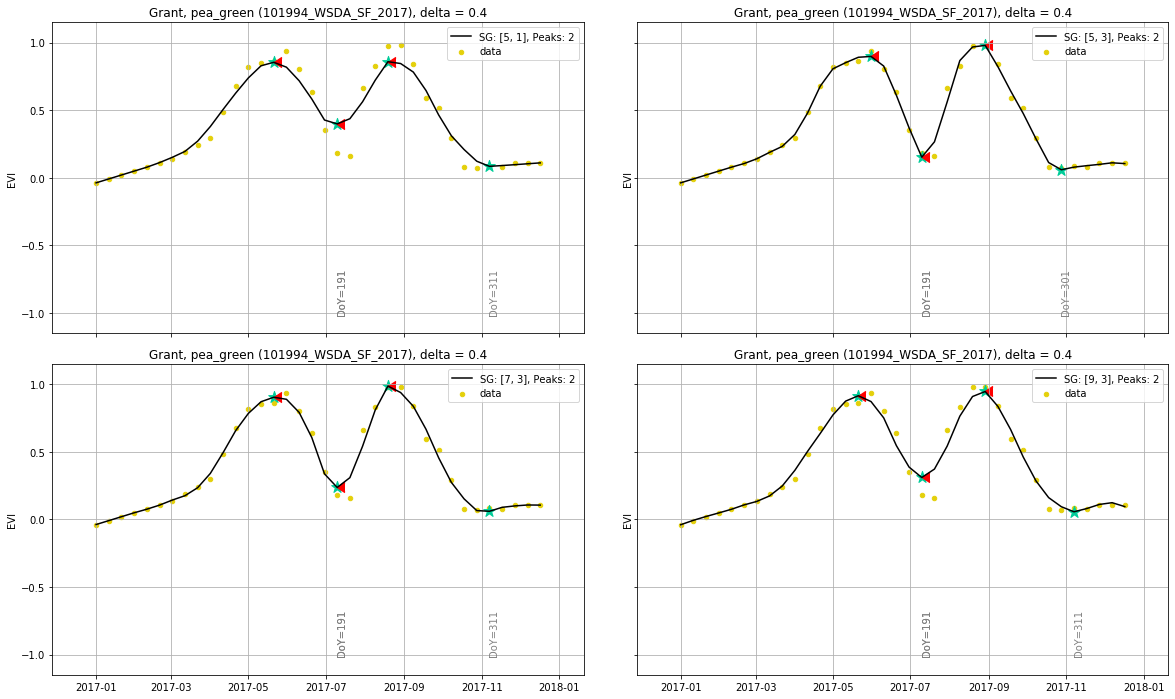

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(20,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2), (ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

rcp.savitzky_1yr_panels_clean_sciPy_and_My_PeakFinder(A_Data = clean_regularized_TS, 
                                                      idx=indeks, SG_params=[5, 1], 
                                                      SFYr=SF_year, ax=ax1, deltA=0.4);

rcp.savitzky_1yr_panels_clean_sciPy_and_My_PeakFinder(A_Data = clean_regularized_TS, 
                                                      idx=indeks, SG_params=[5, 3], 
                                                      SFYr=SF_year, ax=ax2, deltA=0.4); 

rcp.savitzky_1yr_panels_clean_sciPy_and_My_PeakFinder(A_Data = clean_regularized_TS, 
                                                      idx=indeks, SG_params=[7, 3], 
                                                      SFYr=SF_year, ax=ax3, deltA=0.4);

rcp.savitzky_1yr_panels_clean_sciPy_and_My_PeakFinder(A_Data = clean_regularized_TS, 
                                                      idx=indeks, SG_params=[9, 3],
                                                      SFYr=SF_year, ax=ax4, deltA=0.4)

plot_path = "/Users/hn/Desktop/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

fig_name = plot_path + "SciPy_MATLAB_" + county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'
plt.savefig(fname = fig_name, dpi=250, bbox_inches='tight')

## 7. Find SOS and EOS using NDVI ratio of White 
and TIMESAT? finding min and max is already challenging. SOS and EOS depends in these two in TIMESAT.

#### Plot with onset and offset being equal

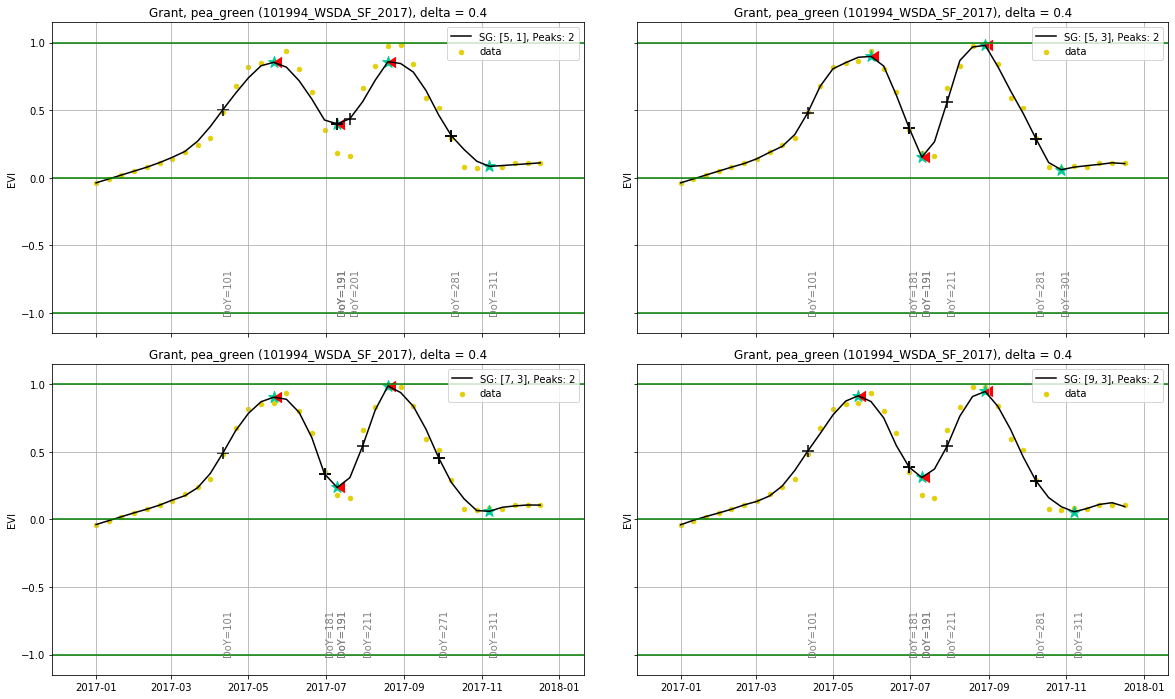

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(20,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2), (ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

sos_thresh = 0.5
eos_thresh = 0.5

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx=indeks, 
                                           SG_params=[5, 1], 
                                           SFYr=SF_year, ax=ax1, deltA=0.4,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx=indeks, SG_params=[5, 3], 
                                           SFYr=SF_year, ax=ax2, deltA=0.4,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh); 

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx = indeks, SG_params=[7, 3],
                                           SFYr = SF_year, ax=ax3, deltA=0.4,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx=indeks, SG_params=[9, 3],
                                           SFYr=SF_year, ax=ax4, deltA=0.4,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh)


plot_path = "/Users/hn/Desktop/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

fig_name = plot_path + "EqualOnOff_SciPy_MATLAB" + \
           county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + \
           '_sosCut_' + str(sos_thresh) + '.png'

plt.savefig(fname = fig_name, dpi=250, bbox_inches='tight')

#### Plot with onset and offset being different

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2), (ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx=indeks, 
                                           SG_params=[5, 1], 
                                           SFYr=SF_year, ax=ax1, deltA=0.4,
                                           onset_cut=0.5, offset_cut=0.6);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx=indeks, SG_params=[5, 3], 
                                           SFYr=SF_year, ax=ax2, deltA=0.4,
                                           onset_cut=0.5, offset_cut=0.6); 

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx = indeks, SG_params=[7, 3],
                                           SFYr = SF_year, ax=ax3, deltA=0.4,
                                           onset_cut=0.5, offset_cut=0.6);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx=indeks, SG_params=[9, 3],
                                           SFYr=SF_year, ax=ax4, deltA=0.4,
                                           onset_cut=0.5, offset_cut=0.6)


plot_path = "/Users/hn/Desktop/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

fig_name = plot_path + "DifferentOnOff_SciPy_MATLAB" + \
           county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'
plt.savefig(fname = fig_name, dpi=250, bbox_inches='tight')

In [ ]:
y = clean_regularized_TS.EVI.values.copy()
SG_pred = scipy.signal.savgol_filter(y, window_length= 5, polyorder=3)
clean_regularized_TS.EVI = SG_pred

In [ ]:
crr_fld = rc.addToDF_SOS_EOS_White(pd_TS = clean_regularized_TS, 
                                   VegIdx = "EVI", 
                                   onset_thresh = 0.5, 
                                   offset_thresh = 0.6)

In [ ]:
crr_fld[crr_fld.SOS.values != 0]

In [ ]:
number_of_rows = len(crr_fld)

SOS_indicator = np.zeros(number_of_rows)
EOS_indicator = np.zeros(number_of_rows)

SOS_indicator[np.where(crr_fld.SOS.values != 0)[0]] = 1
EOS_indicator[np.where(crr_fld.EOS.values != 0)[0]] = 1

In [ ]:
crr_fld.head(2)

In [51]:
"30_cloud_max".split("_")[0]

'30'